# Figure 8: % error in outbreak probability versus initial number of infections

## Abby Barlow, University of Bath
## Ben Adams, University of Bath

### Importing required libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pylab as plt
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import fsolve
import math

### Importing required scripts

In [2]:
import importlib
import Keeling_model
import R_star_construct
import Offspring_dist_neighbourhoods
import Offspring_dist_construction

importlib.reload(Keeling_model)
importlib.reload(R_star_construct)
importlib.reload(Offspring_dist_neighbourhoods)
importlib.reload(Offspring_dist_construction)

ConfigsConstruct = Keeling_model.ConfigsConstruct
RstarAnal = R_star_construct.RstarAnal
Gen_func_s_neigh = Offspring_dist_neighbourhoods.Gen_func_s_neigh
Gen_func_s = Offspring_dist_construction.Gen_func_s

### Parameters

In [3]:
h1,h2 = 840,2520             # no. of households in each neighbourhood
n1,n2 = 6,2                  # size of households for each neighbourhood
gamma = 0.2                  # recovery rate from infection 
days = 100                   # no. of days in simulation
tStart, tEnd = 0, days       # start time and end time (days) of simulation
time_points = np.linspace(tStart, tEnd, days+1)  # time points for Gillespie output, daily
chains = 50000               # no. of runs of SSA

In [4]:
## constructing rho

N_neigh = 2               # no. of neighbourhoods
H = np.array([h1,h2])     # array of number of households in each neighbourhood
N = np.array([n1,n2])     # array of household size for each neighbourhood

p_reserve = np.array([0,0])            # proportion of contacts reserved for own neighbourhood
rho = np.zeros((N_neigh,N_neigh))      # initialising array to store rho values

for i in range(N_neigh): 
    for j in range(N_neigh):
        rho[i,j] = (1-p_reserve[i])*(1-p_reserve[j])*H[j]*N[j]/(np.sum((1-p_reserve)*H*N))
    rho[i,i] = p_reserve[i] + (1-p_reserve[i])*(1-p_reserve[i])*H[i]*N[i]/(np.sum((1-p_reserve)*H*N))

In [5]:
## fixing contact rates alpha and beta

nu = 3     # good range 1 to 6 (2 to 4)
beta = fsolve(RstarAnal,0.5,(gamma,nu))[0]  # solving for beta when fixing R_* to 2.4
alpha = beta/nu                             # beta = nu*alpha

alpha=round(alpha,2)                        # truncating to 2 d.p.
beta=round(beta,2)
alpha,beta

(0.27, 0.8)

### Calculating the outbreak probabilities under various scenarios

In [6]:
nVar = [2,3,4,5,6]                       # list of household sizes neighbourhood 1
hVar = [2520,1680,1260,1008,840]         # list of number of households neighbourhood 1
h2 = 2520                                # number of households neighbourhood 2
n2 = 2                                   # household size neighbourhood 2

# initialise arrays to store various outbreak probabilities
s1 = np.zeros(len(hVar))    # no neighbourhoods, n=6
s2 = np.zeros(len(hVar))    # no neighbourhoods, n=2
ss1 = np.zeros(len(hVar))   # initial case neighbourhood 1
ss2 = np.zeros(len(hVar))   # initial case neighbourhood 2
configs2,n_configs2 = ConfigsConstruct(n2)

for m in range(len(hVar)): # loop over neighbourhood 1 household sizes
    h1 = hVar[m]
    n1 = nVar[m]
    configs1,n_configs1 = ConfigsConstruct(n1)  # defining the set of household configurations
    
    Inf1,Inf2 = 0,1       
    y0 = np.zeros(n_configs1+n_configs2)     # state space is each of the possible household configurations accross the 2 neighbourhoods
    y0[0] = (h1 - Inf1)/h1                   # propn of households neighbourhood 1 made up of susceptibles only
    y0[1] = Inf1/h1                          # propn of households neighbourhood 1 with one initial infected
    y0[n_configs1] = (h2 - Inf2)/h2          # propn of households neighbourhood 2 made up of susceptibles only
    y0[n_configs1+1] = Inf2/h2               # propn of households neighbourhood 2 with one initial infected 
       
    params = (n1,n2,beta,alpha,rho[0,0],gamma,y0)     # parameter sets for each generating function
    params_ = (n1,n2,beta,alpha,rho[0,0],gamma,y0)
    params1 = (n1,n2,beta,alpha,rho[0,0],gamma,y0,0,50)
    params2 = (n1,n2,beta,alpha,rho[0,0],gamma,y0,1,50)
    ss1[m] = fsolve(Gen_func_s_neigh,(0.5,0.5), args=params)[0]  # correct BP approximation
    ss2[m] = fsolve(Gen_func_s_neigh,(0.5,0.5), args=params)[1]  # correct BP approximation
    s1[m] = fsolve(Gen_func_s,0.5, args=params1)
    s2[m] = fsolve(Gen_func_s,0.5, args=params2)

### Producing figure
#### (a)

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


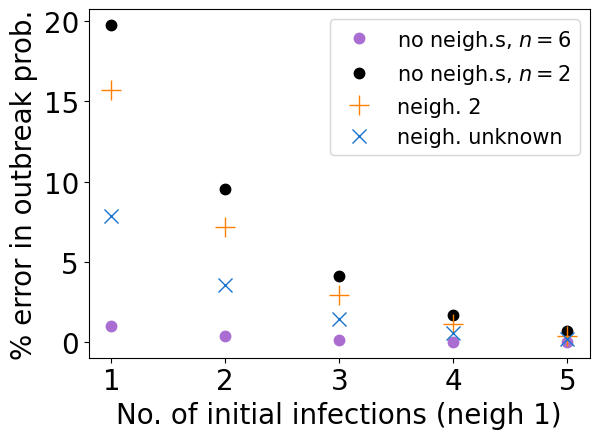

In [7]:
plt.rcParams.update({'font.size': 20})
num_infs = np.arange(1,6,1)  # list of no. of initial infections in neighbourhood 1
no_neigh1 = np.zeros((len(num_infs),len(hVar)))   # initialising  arrays to store error in outbreak probs
no_neigh2 = np.zeros((len(num_infs),len(hVar)))
neigh_2 = np.zeros((len(num_infs),len(hVar)))
neigh_unknown = np.zeros((len(num_infs),len(hVar)))

for i in range(len(num_infs)):   # looping over number of initial infections in neighbourhood 1
    k1=num_infs[i]
    no_neigh1[i,:]=((1-s1**k1)-(1-ss1**k1))/(1-ss1**k1)
    no_neigh2[i,:]=((1-s2**k1)-(1-ss1**k1))/(1-ss1**k1)
    neigh_2[i,:]=((1-ss2**k1)-(1-ss1**k1))/(1-ss1**k1)
    neigh_unknown[i,:]=(((1-ss1**k1)+(1-ss2**k1))/2-(1-ss1**k1))/(1-ss1**k1)

# plotting errors for each outbreak prob scenario vs no. of initial infections
plt.plot(num_infs,abs(no_neigh1[:,4]*100),'.', color = '#AA6DD1', markersize = 15, label=r'no neigh.s, $n=6$')
plt.plot(num_infs,abs(no_neigh2[:,4]*100),'.', color='black', markersize = 15, label=r'no neigh.s, $n=2$')
plt.plot(num_infs,abs(neigh_2[:,4]*100),'+', color= '#FF8000', markersize = 15, label='neigh. 2')
plt.plot(num_infs,abs(neigh_unknown[:,4]*100), 'x', color='#1874CD', markersize = 10, label='neigh. unknown')

plt.xlabel(r'No. of initial infections (neigh 1)')
plt.ylabel('% error in outbreak prob.')
#plt.title(r'$n_1=${}, $n_2=${}, $\nu=${}, $r=${}'.format(n1,n2,nu,p_reserve[0]))
plt.xticks([1,2,3,4,5])
plt.yticks([0,5,10,15,20])
plt.legend(fontsize=15)
plt.tight_layout()
#plt.savefig('outbreak_prob_surv_error1.pdf', bbox_inches='tight')

#### (b)

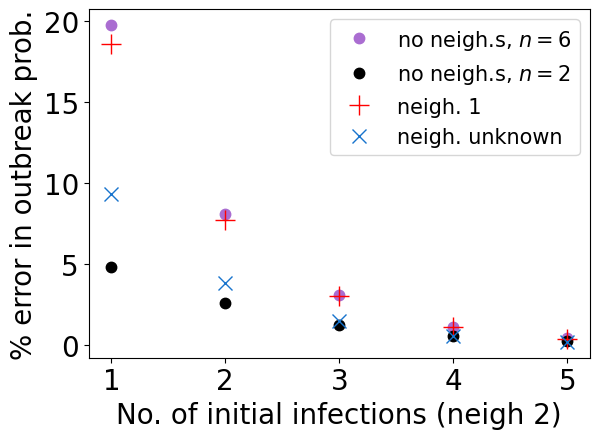

In [8]:
plt.rcParams.update({'font.size': 20})
num_infs = np.arange(1,6,1)      # list of no. of initial infections in neighbourhood 2
no_neigh1 = np.zeros((len(num_infs),len(hVar)))   # initialising  arrays to store error in outbreak probs
no_neigh2 = np.zeros((len(num_infs),len(hVar)))
neigh_1 = np.zeros((len(num_infs),len(hVar)))
neigh_unknown = np.zeros((len(num_infs),len(hVar)))

for i in range(len(num_infs)):   # looping over number of initial infections in neighbourhood 2
    k1=num_infs[i]
    no_neigh1[i,:]=((1-s1**k1)-(1-ss2**k1))/(1-ss2**k1)
    no_neigh2[i,:]=((1-s2**k1)-(1-ss2**k1))/(1-ss2**k1)
    neigh_1[i,:]=((1-ss1**k1)-(1-ss2**k1))/(1-ss2**k1)
    neigh_unknown[i,:]=(((1-ss1**k1)+(1-ss2**k1))/2-(1-ss2**k1))/(1-ss2**k1)

# plotting errors for each outbreak prob scenario vs no. of initial infections
plt.plot(num_infs,abs(no_neigh1[:,4]*100),'.', color = '#AA6DD1', markersize = 15, label=r'no neigh.s, $n=6$')
plt.plot(num_infs,abs(no_neigh2[:,4]*100),'.', color='black', markersize = 15, label=r'no neigh.s, $n=2$')
plt.plot(num_infs,abs(neigh_1[:,4]*100),'+', color='#FF0000', markersize = 15, label='neigh. 1')
plt.plot(num_infs,abs(neigh_unknown[:,4]*100), 'x', color='#1874CD', markersize = 10, label='neigh. unknown')

plt.xlabel(r'No. of initial infections (neigh 2)')
plt.ylabel('% error in outbreak prob.')
#plt.title(r'$n_1=${}, $n_2=${}, $\nu=${}, $r=${}'.format(n1,n2,nu,p_reserve[0]))
plt.xticks([1,2,3,4,5])
plt.yticks([0,5,10,15,20])
plt.legend(fontsize=15)
plt.tight_layout()
#plt.savefig('outbreak_prob_surv_error2.pdf', bbox_inches='tight')

The relative error in the probability of an outbreak occurring originating $k=1,2,\ldots , 5$ infectious individuals (a) from neighbourhood $1$, $n_1=6$ and (b) from neighbourhood $2$, $n_2=2$ under various assumptions. Assumptions: single neighbourhood population of households size $6 (=n_1)$ (blue pluses); single neighbourhood of households size $2 (=n_2)$; initial infected individual from the other neighbourhood (green crosses) and from an unknown neighbourhood (red stars).